In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf

torch threads 1
Running on device cpu


In [2]:
import torch
import pyro

import pyro.distributions as dist

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import jsonpickle as pickle
import json
import gc
# import pickle
import gc

from scipy.stats import ttest_1samp

In [3]:
results_folder = "results"
simulation_folder = os.path.join(results_folder, "simulations")
recovery_folder = os.path.join(results_folder, "recovery")
cross_fitting_folder = os.path.join(results_folder, "cross_fitting")

# processed_data_folder = os.path.join("processed_data")

In [4]:
results_folder = os.path.join("results")
processed_data_folder = os.path.join("processed_data")

mask_file_name = "mask.pkl"
mask_file = os.path.join(processed_data_folder, mask_file_name)

Rho_fname = "Rho.pkl"
Rho_file = os.path.join(processed_data_folder, Rho_fname)

In [5]:
n_agents = 24
trials =  272#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, 'r') as infile:
    loaded = json.load(infile)
all_mask = pickle.decode(loaded)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask)#.permute((1,0))
# exp mask knows the subject specific lengths
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.7390)


In [6]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

In [7]:
def load_simulated_data(base_dir, agent_type):
    print("loading simulated outputs...")

    stayed_arr, true_vals, data = tu.load_simulation_outputs(base_dir, agent_type)

    n_true = true_vals["subject"].max() + 1
    n_data = data["subject"].max() + 1

    assert n_true == n_data == n_agents, f"the numbers of agents dont match! They are: {n_true}, {n_data}, {n_agents}. Probably rerun simulations to fix."

    print("true values are:")
    print(true_vals)

    return true_vals, data

In [8]:
def load_BCC_results(infer_h, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [9]:
def load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [10]:
def calculate_log_likelihood(data, agent, locs_df, npars, trials, T):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # this is the likelihood of the average parameter

    n_agents = data["actions"].shape[-1]
    log_like = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))

                log_like += torch.log(masked_probs)

    return log_like.clone().detach()
    

In [11]:
def calculate_BIC(data, agent, locs_df, npars, trials, T):

    # use bic to circumvent the number of trials problem

    n_agents = data["actions"].shape[-1]
    BIC = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor(0.5))

                print(masked_probs.shape)

                BIC -= 2*torch.log(masked_probs)

    # question: is it noraml that the first term of the BIC (k*ln(n)) is much smaller than the second (-2*ln(L))?
    BIC += npars*torch.log(data["valid"].sum(axis=0))

    return BIC
    

In [12]:
def calculate_lppd(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (4,5) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average likelihood

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)

    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    mean_log_like = torch.log(mean_like).sum(dim=0)

    #print(mean_log_like)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    return mean_log_like.clone().detach()
    

In [13]:
def calculate_waic(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (12,13) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average WAIC
    # are the larger number of params handled correctly?

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)



    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like_samples = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    lppd = torch.log(mean_like_samples).sum(dim=0)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    mean_log_like_samples = torch.log(mean_like.sum(dim=-2)) / n_samples

    V_s = ((torch.log(mean_like) - mean_log_like_samples[:,None,:])**2).sum(dim=-2) / (n_samples-1)

    p_waic = V_s.sum(dim=0)

    ellp_waic = lppd - p_waic

    # text says it needs to be -2 * eq 13.
    # minus is required to make lower better, and the 2 converts it to variance scale

    return ellp_waic.clone().detach()
    

In [14]:
def predictive_accuracy_mean_param(data, agent, locs_df, npars, trials, T):

    n_agents = data["actions"].shape[-1]

    predicted_accuracy = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    num_valid_responses = torch.zeros(data["actions"].shape[-1])

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:
                #print(tau,t)

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]#*data["valid"][tau].long()
                #print(curr_response)

                predicted_response = torch.argmax(probs, dim=0)[0]

                #print(probs)

                #print(predicted_response)

                correct_response_predicted = (curr_response == predicted_response).int()

                #print(correct_response_predicted)

                predicted_accuracy += correct_response_predicted

                num_valid_responses += data["valid"][tau]

                #print(num_valid_responses)


    corrected_predicted_accuracy = predicted_accuracy / num_valid_responses

    return corrected_predicted_accuracy

In [15]:
def calculate_exceedance_prob(measure, n_exc_samples=500):
    
    p_model = torch.nn.functional.softmax(measure, dim=-1)

    print("p model mean according to measure", p_model.mean(dim=0))

    dirichlet_counts = p_model.sum(dim=0)

    model_prob_dirichlet = dist.Dirichlet(dirichlet_counts)

    n_exc_samples = 500

    dir_samples = model_prob_dirichlet.sample(sample_shape=torch.tensor([n_exc_samples]))

    avg_best_model = dir_samples.mean(dim=0).argmax()

    best_model = dir_samples.argmax(dim=1)

    exc_prob = (best_model == avg_best_model).sum()/n_exc_samples

    print("best model:", avg_best_model, "exceedance prob", exc_prob)

    significant_best_model = ttest_1samp(dir_samples[:,avg_best_model], 1./measure.shape[-1], alternative="greater")

    print("is significantly different from uniform?", significant_best_model)

# 1. True agent = BCC3

In [16]:
# load BCC3 data

BCC3_infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if BCC3_infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC3_param_names = param_names.copy()

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for loading results
# make base filename and folder string
BCC3_agent_type = prefix+h_str
BCC3_data_fname_base = prefix+h_str+"_simulation_"
print(BCC3_data_fname_base)
# define folder where we want to save data
BCC3_data_base_dir = os.path.join(simulation_folder,BCC3_data_fname_base[:-1])

BCC3_true_vals, BCC3_data = load_simulated_data(BCC3_data_base_dir, BCC3_agent_type)

BCC_3param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]]), 'policy rate': tensor([[0.7084, 0.4013, 0.5615, 0.9277, 0.5900, 0.5154, 0.6533, 0.6219, 0.0499,
         0.0635, 0.8817, 0.8136, 0.1098, 0.3712, 0.0146, 0.5976, 0.7021, 0.6399,
         0.4803, 0.6894, 0.1267, 0.6184, 0.9975, 0.1210]]), 'reward rate': tensor([[0.4463, 0.5140, 0.8804, 0.2720, 0.7343, 0.0202, 0.6105, 0.7642, 0.9716,
         0.1601, 0.8785, 0.8070, 0.5683, 0.9671, 0.5136, 0.1659, 0.7656, 0.3306,
         0.3826, 0.3969, 0.5665, 0.1444, 0.2872, 0.8608]]), 'dec temp': tensor([[6.8474, 2.4711, 6.4944, 1.4452, 4.5654, 4.4945, 3.8269, 3.8210, 1.7222,
         3.6656, 3.9180, 1.2781, 2.1527, 3.9341, 1.4062, 1.3634, 2.7387, 1.4474,
         6.0293, 2.0273, 6.3898, 6.9751, 5.5270, 1.1392]]), 'habitual tendency': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

BCC_3param_recovery_
analyzing 24 data sets


/home/sarah/src/BayesianTwoStageTaskAnalysis/FeherDaSilva_magic_carpet_data/../code/BalancingControl/perception.py:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

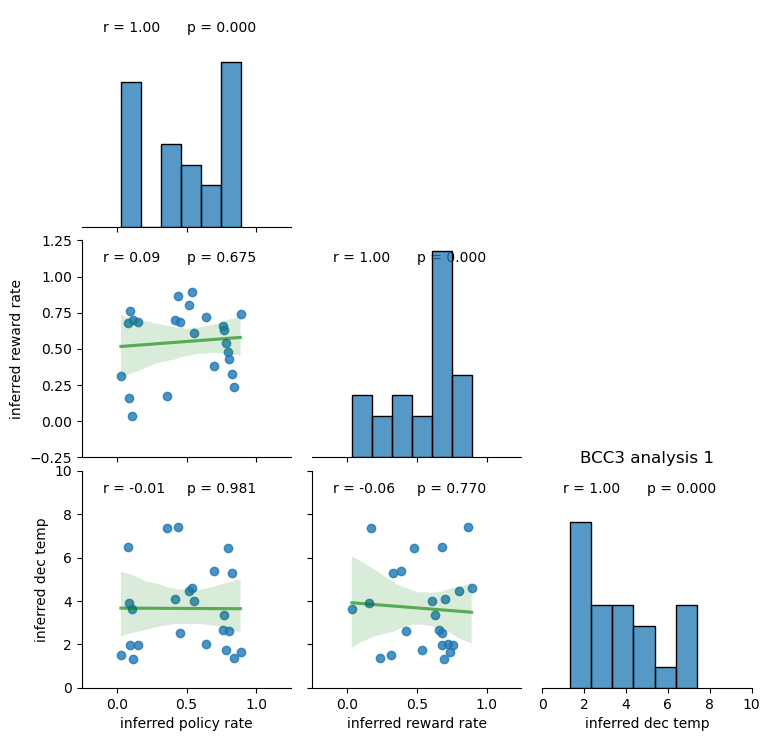

In [17]:
# load BCC3 fitting of BCC3 data

BCC3_BCC3_fname_base = BCC3_agent_type+"_recovery_"
print(BCC3_BCC3_fname_base)
# define folder where we want to save data
BCC3_BCC3_base_dir = os.path.join(recovery_folder,BCC3_BCC3_fname_base[:-1])

num_steps = 600

BCC3_BCC3_mean_df, BCC3_BCC3_sample_df, BCC3_BCC3_locs_df = load_BCC_results(BCC3_infer_h, BCC3_BCC3_base_dir, 
                                                                             global_experiment_parameters, exp_mask, BCC3_BCC3_fname_base, 
                                                                             num_steps, BCC3_data, BCC3_param_names)
BCC3_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, BCC3_BCC3_base_dir, global_experiment_parameters, 
                                                     BCC3_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=BCC3_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


In [18]:
# BCC4 agent

BCC4_infer_h = True

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if BCC4_infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC4_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for loading results
# make base filename and folder string
BCC4_agent_type = prefix+h_str
BCC4_data_fname_base = prefix+h_str+"_simulation_"
print(BCC4_data_fname_base)
# define folder where we want to save data
BCC4_data_base_dir = os.path.join(simulation_folder,BCC4_data_fname_base[:-1])

BCC4_true_vals, BCC4_data = load_simulated_data(BCC4_data_base_dir, BCC4_agent_type)

BCC_4param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]]), 'policy rate': tensor([[0.4998, 0.0384, 0.7324, 0.6668, 0.4508, 0.1407, 0.6434, 0.9947, 0.2451,
         0.0758, 0.1145, 0.4303, 0.4235, 0.5003, 0.9488, 0.5010, 0.5310, 0.8570,
         0.8955, 0.1623, 0.6945, 0.6408, 0.4708, 0.6174]]), 'reward rate': tensor([[0.9798, 0.4714, 0.0733, 0.9727, 0.4174, 0.9465, 0.3292, 0.5774, 0.2437,
         0.0356, 0.5959, 0.5653, 0.4571, 0.9052, 0.0676, 0.0069, 0.2240, 0.6780,
         0.5486, 0.8368, 0.9999, 0.3905, 0.0422, 0.8595]]), 'dec temp': tensor([[2.4189, 4.3153, 2.7330, 4.3709, 4.3087, 6.3243, 6.7096, 6.5593, 2.5700,
         6.0397, 1.0248, 4.4054, 2.0719, 3.4263, 4.1130, 4.7377, 6.9034, 3.2512,
         3.7578, 1.1388, 4.4368, 4.2993, 5.1994, 6.1184]]), 'habitual tendency': tensor([[0.9312, 0.6140, 0.5159, 0.1554, 0.2228, 0.6190, 0.1748, 0.9564, 

BCC3param_cross_fitting_BCC_4param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

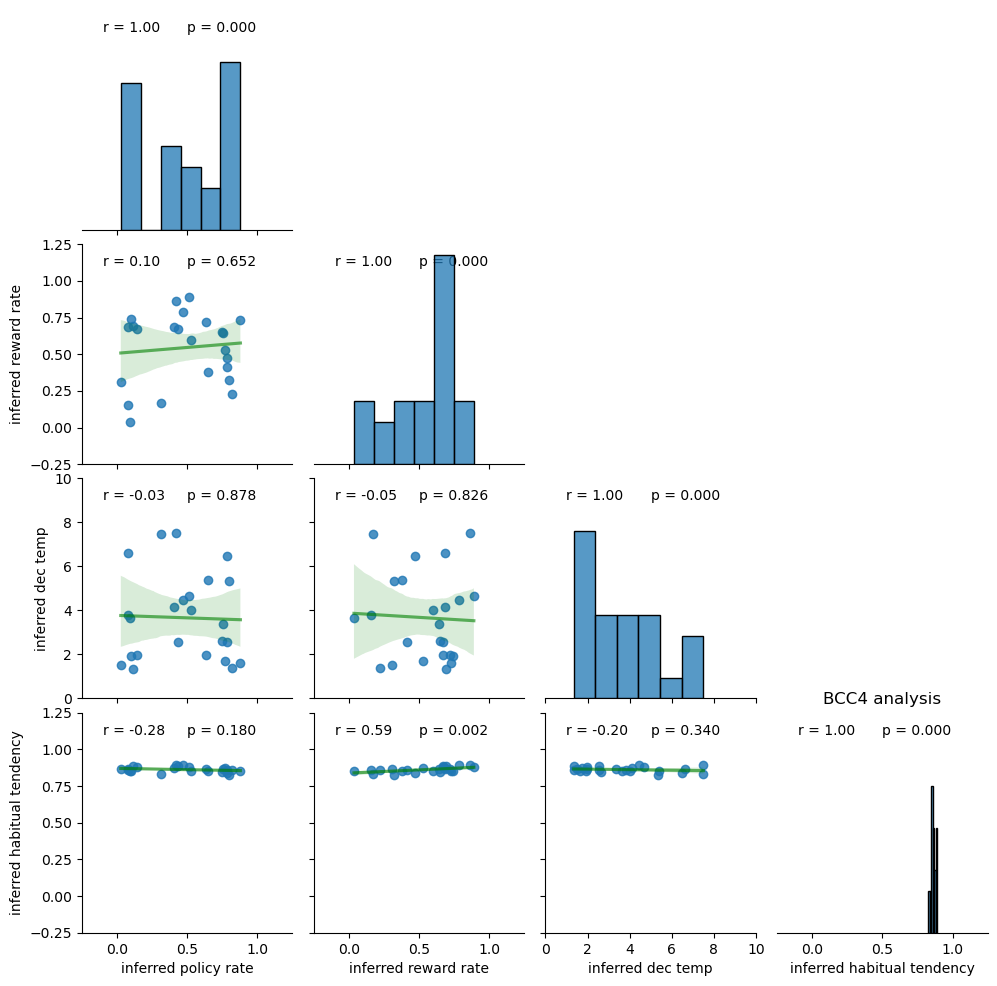

In [19]:
BCC3_BCC4_fname_base = "BCC3param_cross_fitting_"+BCC4_agent_type
print(BCC3_BCC4_fname_base)
# define folder where we want to save data
BCC3_BCC4_base_dir = os.path.join(cross_fitting_folder,BCC3_BCC4_fname_base[:-1])

num_steps = 600

BCC3_BCC4_mean_df, BCC3_BCC4_sample_df, BCC3_BCC4_locs_df = load_BCC_results(BCC4_infer_h, BCC3_BCC4_base_dir, 
                                                                             global_experiment_parameters, exp_mask, 
                                                                             BCC3_BCC4_fname_base, num_steps, BCC3_data, BCC4_param_names)
BCC3_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, BCC3_BCC4_base_dir, 
                                                     global_experiment_parameters, BCC3_data["valid"], remove_old=False)

BCC4_param_ranges = [[0,1], [0,1], [0,max_dt], [0,1]]
BCC4_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10], [-0.25,1.25]]
BCC4_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


In [20]:
# MFMB4 analysis

# set parameters and their names

use_orig = False

MFMB4_use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if MFMB4_use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB4_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
MFMB4_agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

MFMB4_data_fname_base = MFMB4_agent_type+"_simulation_"
print(MFMB4_data_fname_base)
# define folder where we want to save data
MFMB4_data_base_dir = os.path.join(simulation_folder,MFMB4_data_fname_base[:-1])

MFMB4_true_vals, MFMB4_data = load_simulated_data(MFMB4_data_base_dir, MFMB4_agent_type)

mbmf_4param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]]), 'discount': tensor([[0.1597, 0.6867, 0.0051, 0.0488, 0.2269, 0.5804, 0.7652, 0.6020, 0.4287,
         0.9152, 0.9673, 0.6512, 0.1654, 0.9390, 0.7622, 0.6167, 0.4560, 0.8998,
         0.9934, 0.0686, 0.4158, 0.8649, 0.2884, 0.1223]]), 'learning rate': tensor([[0.8005, 0.3207, 0.3054, 0.7071, 0.9622, 0.8252, 0.5026, 0.6800, 0.1833,
         0.8341, 0.2825, 0.5448, 0.3548, 0.8768, 0.7473, 0.4197, 0.9723, 0.4417,
         0.3284, 0.3269, 0.8399, 0.4132, 0.0246, 0.1293]]), 'mf weight': tensor([[2.6154, 5.9025, 3.1007, 1.3961, 1.4997, 5.4128, 1.6530, 0.6856, 0.5252,
         3.4135, 2.2514, 4.2994, 3.6306, 5.8824, 0.5009, 3.2185, 0.4603, 2.1323,
         4.8635, 0.6904, 3.2861, 5.2165, 2.3217, 4.3435]]), 'mb weight': tensor([[3.3301, 5.1825, 3.3751, 2.9850, 5.0070, 0.0627, 1.9515, 2.5859, 5.2173,

BCC3param_cross_fitting_mbmf_4param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

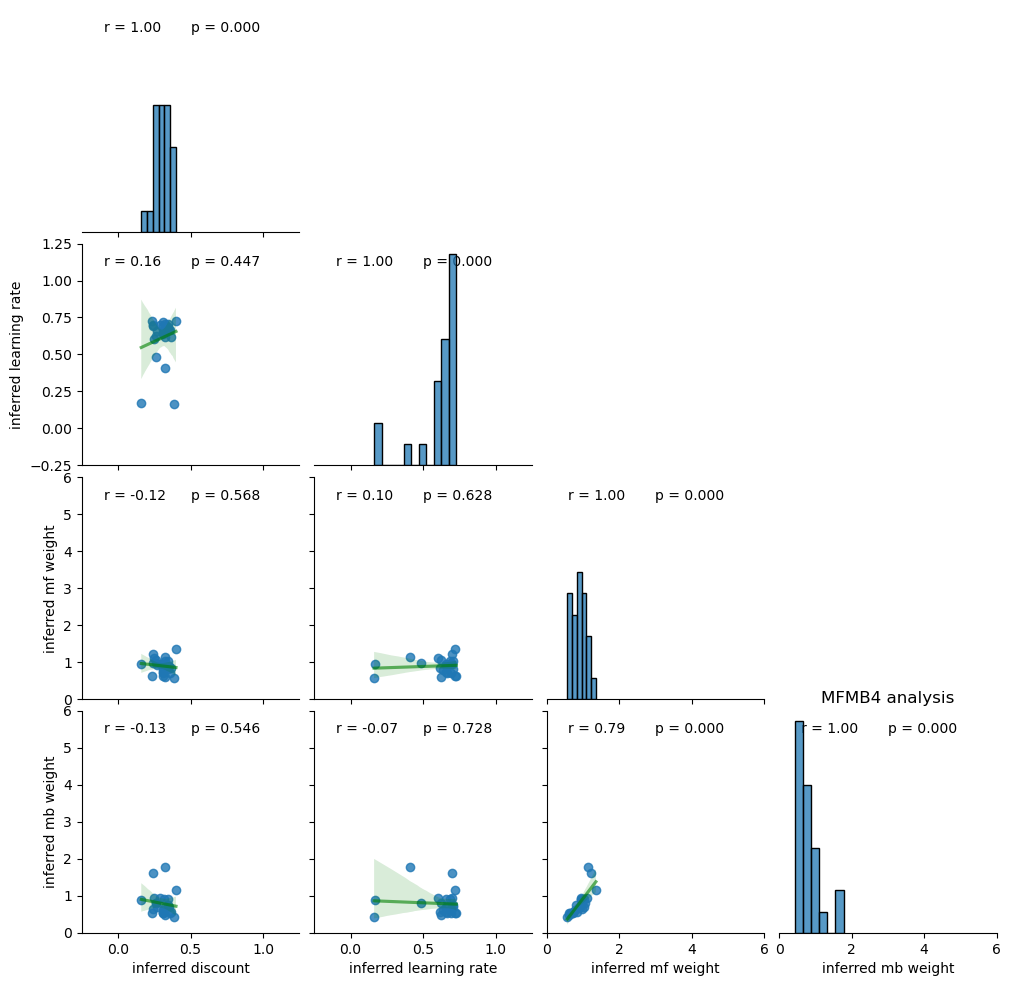

In [21]:
# prepare for saving results
# make base filename and folder string
BCC3_MFMB4_fname_base = "BCC3param_cross_fitting_"+MFMB4_agent_type
print(BCC3_MFMB4_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC3_MFMB4_base_dir = os.path.join(cross_fitting_folder,BCC3_MFMB4_fname_base[:-1])

num_steps = 500

BCC3_MFMB4_mean_df, BCC3_MFMB4_sample_df, BCC3_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, 
                                                                                 BCC3_MFMB4_base_dir, global_experiment_parameters, 
                                                                                 BCC3_data["valid"], BCC3_MFMB4_fname_base, num_steps, 
                                                                                 BCC3_data, MFMB4_param_names)

BCC3_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, 
                                                  restrict_alpha, max_dt, min_alpha, 
                                                  BCC3_MFMB4_base_dir, global_experiment_parameters, 
                                                  BCC3_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=BCC3_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

In [22]:
# MFMB5 analysis

# set parameters and their names

use_orig = False

MFMB5_use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if MFMB5_use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB5_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
MFMB5_agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

MFMB5_data_fname_base = MFMB5_agent_type+"_simulation_"
print(MFMB5_data_fname_base)
# define folder where we want to save data
MFMB5_data_base_dir = os.path.join(simulation_folder,MFMB5_data_fname_base[:-1])

MFMB5_true_vals, MFMB5_data = load_simulated_data(MFMB5_data_base_dir, MFMB5_agent_type)

mbmf_5param_simulation_
loading simulated outputs...
true values are:
{'subject': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]]), 'discount': tensor([[0.2639, 0.3689, 0.3430, 0.5130, 0.1733, 0.6531, 0.0219, 0.5532, 0.6396,
         0.8642, 0.4464, 0.2513, 0.6959, 0.3952, 0.9562, 0.6817, 0.4462, 0.7803,
         0.9621, 0.3658, 0.9147, 0.3648, 0.3594, 0.2265]]), 'learning rate': tensor([[0.8211, 0.1517, 0.9735, 0.8029, 0.6366, 0.7068, 0.5709, 0.7039, 0.8545,
         0.5669, 0.0919, 0.6224, 0.3880, 0.7099, 0.6228, 0.2604, 0.5755, 0.8878,
         0.4641, 0.8016, 0.3063, 0.7022, 0.3893, 0.1373]]), 'mf weight': tensor([[2.0756, 3.7712, 2.1379, 4.8262, 0.7331, 4.8437, 2.4492, 5.2293, 0.2341,
         0.2535, 3.1547, 5.4067, 2.8499, 5.2433, 3.1662, 2.8389, 5.9287, 1.4934,
         0.8310, 3.3186, 5.2222, 3.8793, 5.5618, 5.2869]]), 'mb weight': tensor([[5.0827e+00, 2.7853e+00, 1.3694e+00, 4.9254e+00, 4.8898e+00, 2.5758e+00,

BCC3param_cross_fitting_mbmf_5param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

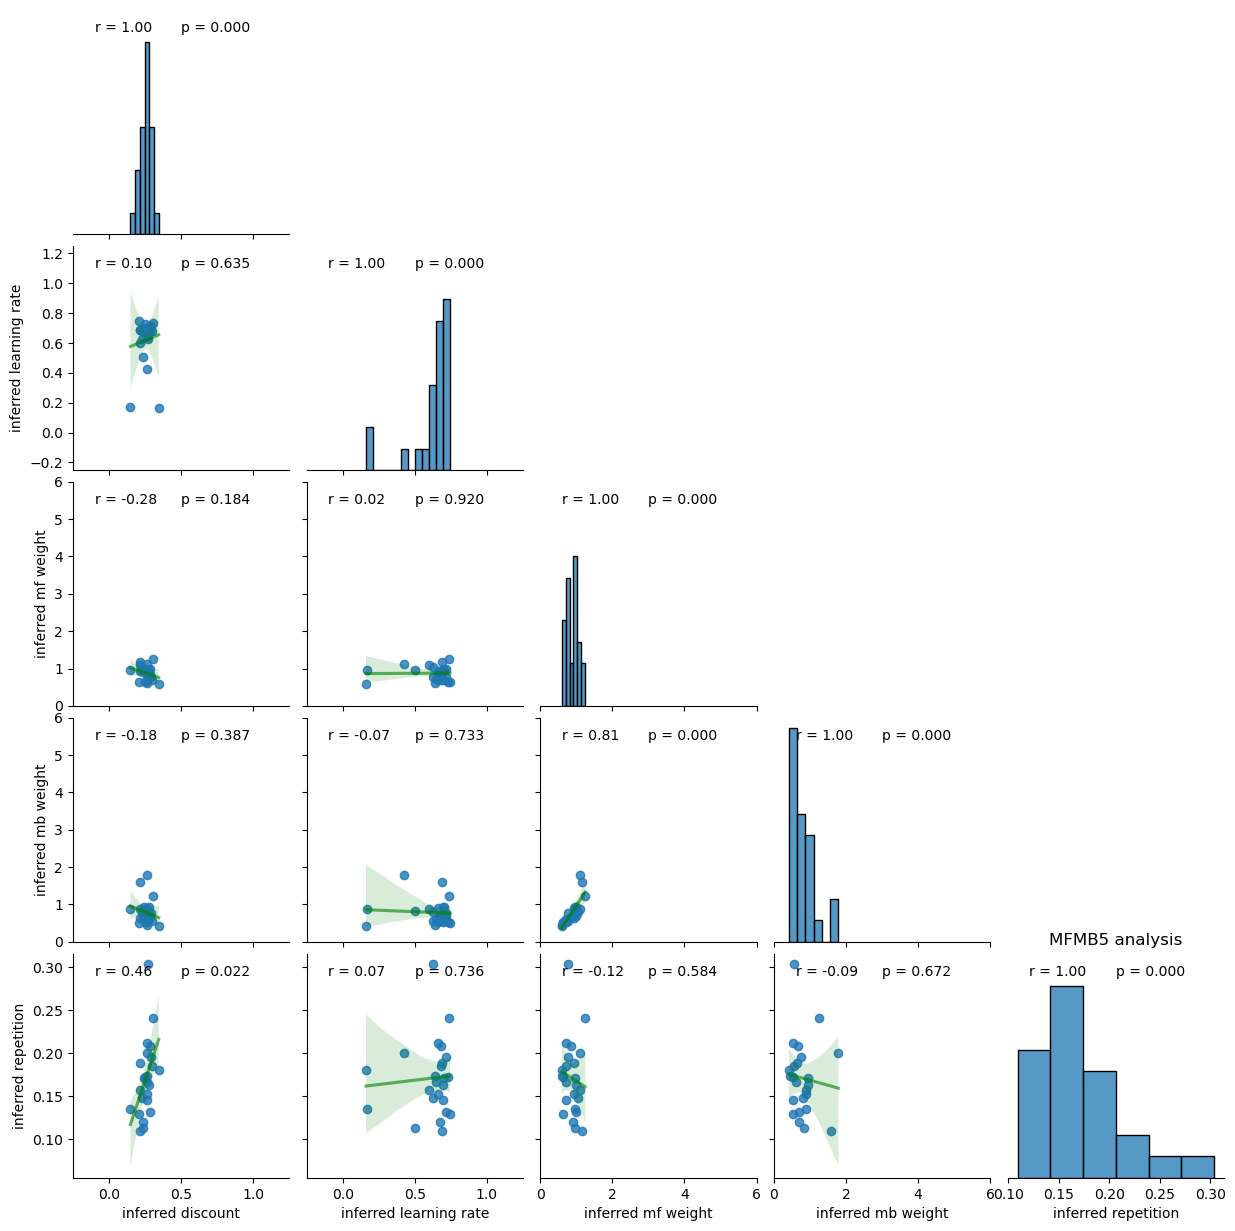

In [23]:
# prepare for saving results
# make base filename and folder string
BCC3_MFMB5_fname_base = "BCC3param_cross_fitting_"+MFMB5_agent_type
print(BCC3_MFMB5_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC3_MFMB5_base_dir = os.path.join(cross_fitting_folder,BCC3_MFMB5_fname_base[:-1])

num_steps = 500

BCC3_MFMB5_mean_df, BCC3_MFMB5_sample_df, BCC3_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, 
                                                                                 restrict_alpha, max_dt, BCC3_MFMB5_base_dir, 
                                                                                 global_experiment_parameters, BCC3_data["valid"], 
                                                                                 BCC3_MFMB5_fname_base, num_steps, BCC3_data, MFMB5_param_names)

BCC3_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, 
                                                  max_dt, min_alpha, BCC3_MFMB5_base_dir, global_experiment_parameters, 
                                                  BCC3_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# 2. BCC4 Data

BCC4param_cross_fitting_BCC_3param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

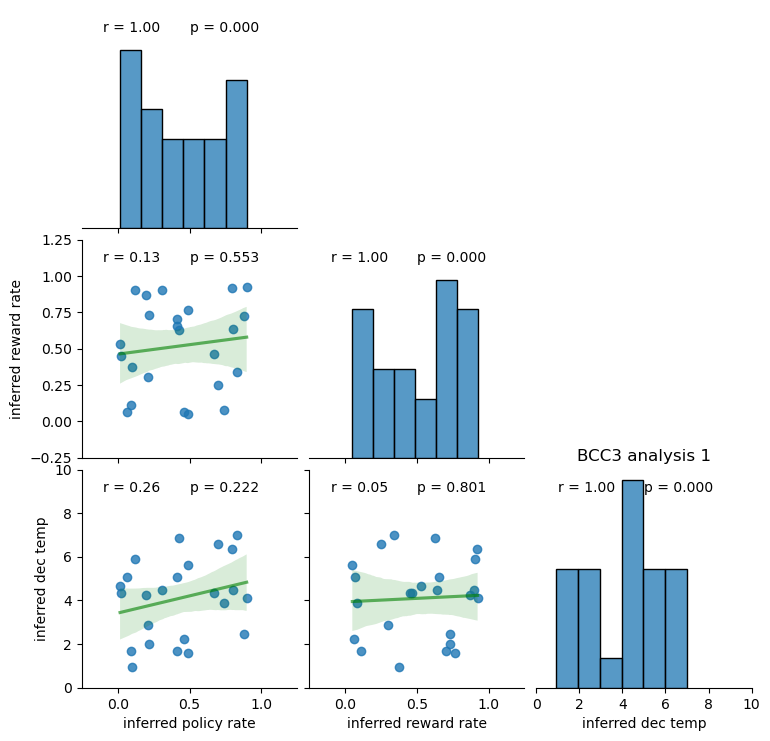

In [24]:
# load BCC3 fitting of BCC4 data

BCC4_BCC3_fname_base = "BCC4param_cross_fitting_"+BCC3_agent_type
print(BCC4_BCC3_fname_base)
# define folder where we want to save data
BCC4_BCC3_base_dir = os.path.join(cross_fitting_folder,BCC4_BCC3_fname_base[:-1])

num_steps = 600

BCC4_BCC3_mean_df, BCC4_BCC3_sample_df, BCC4_BCC3_locs_df = load_BCC_results(BCC3_infer_h, BCC4_BCC3_base_dir, 
                                                                             global_experiment_parameters, exp_mask, 
                                                                             BCC4_BCC3_fname_base, num_steps, BCC4_data, BCC3_param_names)
BCC4_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, BCC4_BCC3_base_dir, 
                                                     global_experiment_parameters, BCC4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=BCC4_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

BCC_4param_recovery_
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

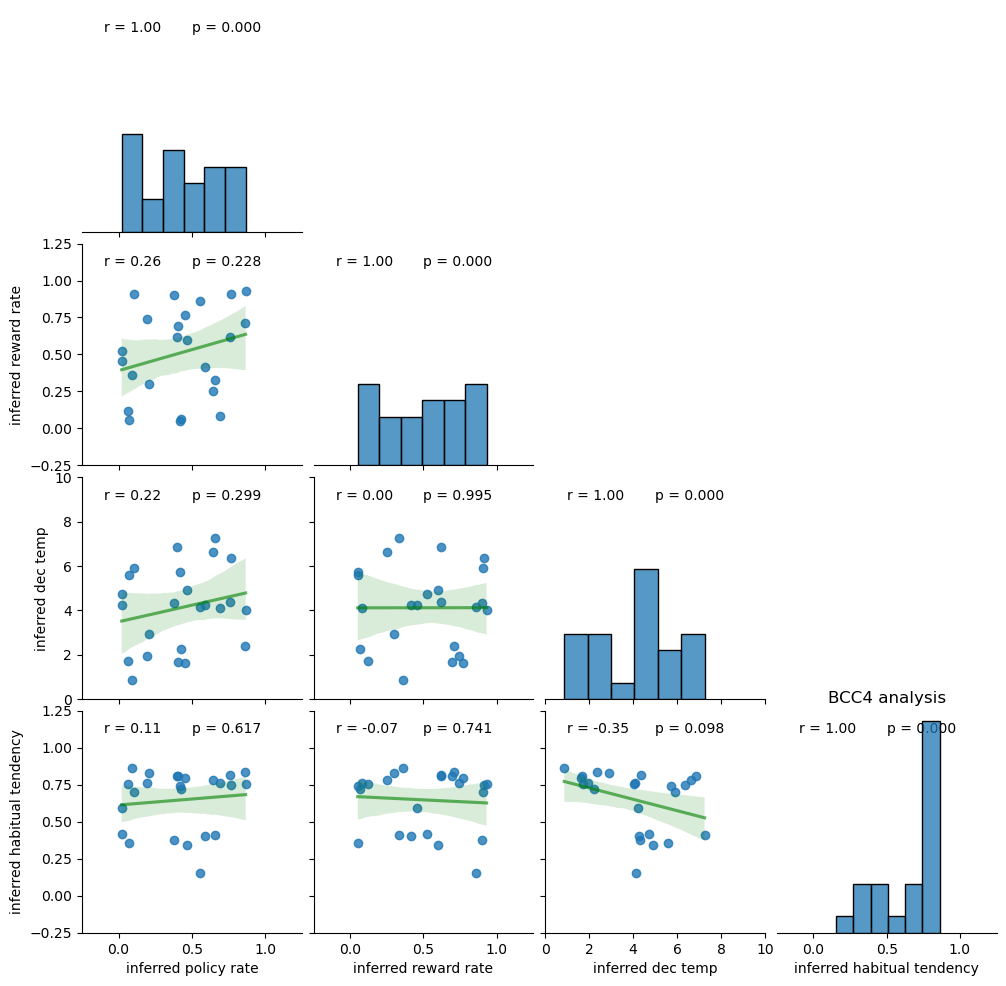

In [25]:
# BCC4 agent for BCC4 data


BCC4_BCC4_fname_base = BCC4_agent_type+"_recovery_"
print(BCC4_BCC4_fname_base)
# define folder where we want to save data
BCC4_BCC4_base_dir = os.path.join(recovery_folder,BCC4_BCC4_fname_base[:-1])

num_steps = 600

BCC4_BCC4_mean_df, BCC4_BCC4_sample_df, BCC4_BCC4_locs_df = load_BCC_results(BCC4_infer_h, BCC4_BCC4_base_dir, 
                                                                             global_experiment_parameters, exp_mask, 
                                                                             BCC4_BCC4_fname_base, num_steps, BCC4_data, BCC4_param_names)
BCC4_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, BCC4_BCC4_base_dir, 
                                                     global_experiment_parameters, BCC4_data["valid"], remove_old=False)

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC4_param_names]
f = sns.pairplot(data=BCC4_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

BCC4param_cross_fitting_mbmf_4param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

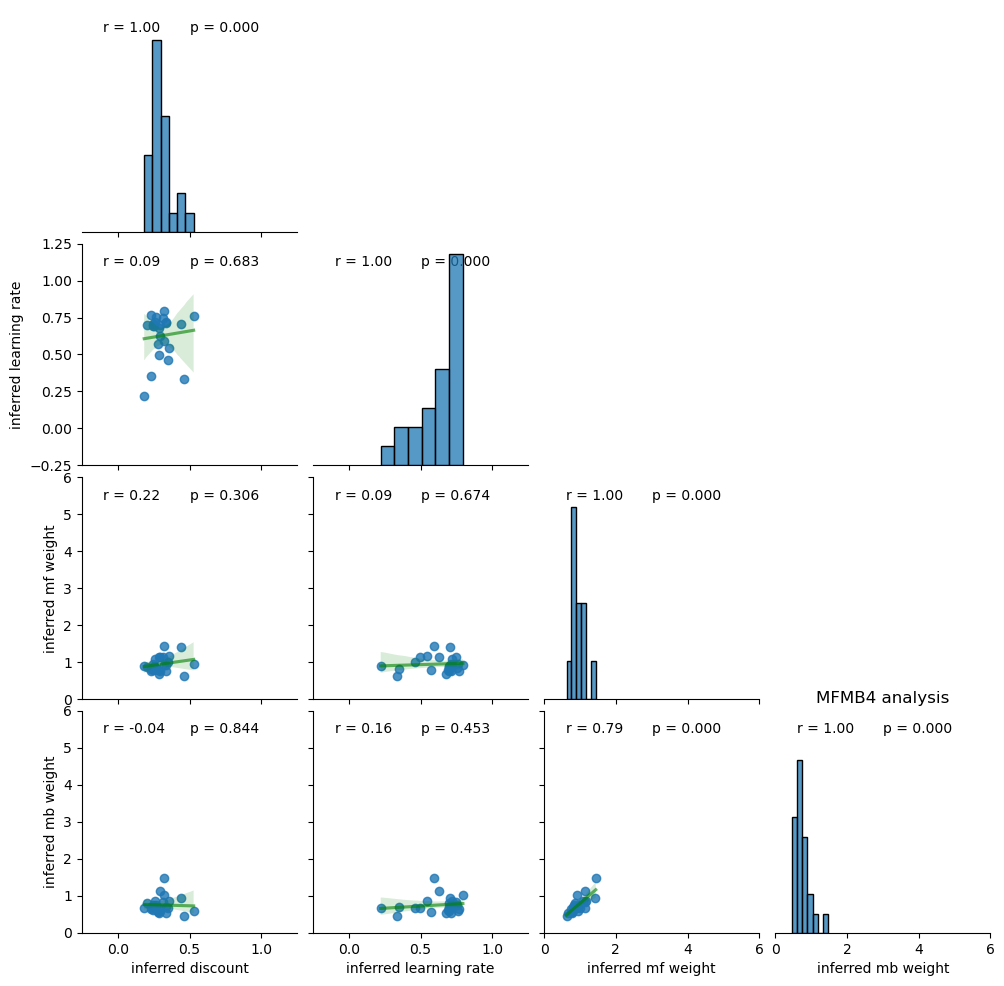

In [26]:
# prepare for saving results
# make base filename and folder string
BCC4_MFMB4_fname_base = "BCC4param_cross_fitting_"+MFMB4_agent_type
print(BCC4_MFMB4_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC4_MFMB4_base_dir = os.path.join(cross_fitting_folder,BCC4_MFMB4_fname_base[:-1])

num_steps = 500

BCC4_MFMB4_mean_df, BCC4_MFMB4_sample_df, BCC4_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, BCC4_MFMB4_base_dir, global_experiment_parameters, BCC4_data["valid"], BCC4_MFMB4_fname_base, num_steps, BCC4_data, MFMB4_param_names)

BCC4_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, restrict_alpha, max_dt, min_alpha, BCC4_MFMB4_base_dir, global_experiment_parameters, BCC4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=BCC4_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

BCC4param_cross_fitting_mbmf_5param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

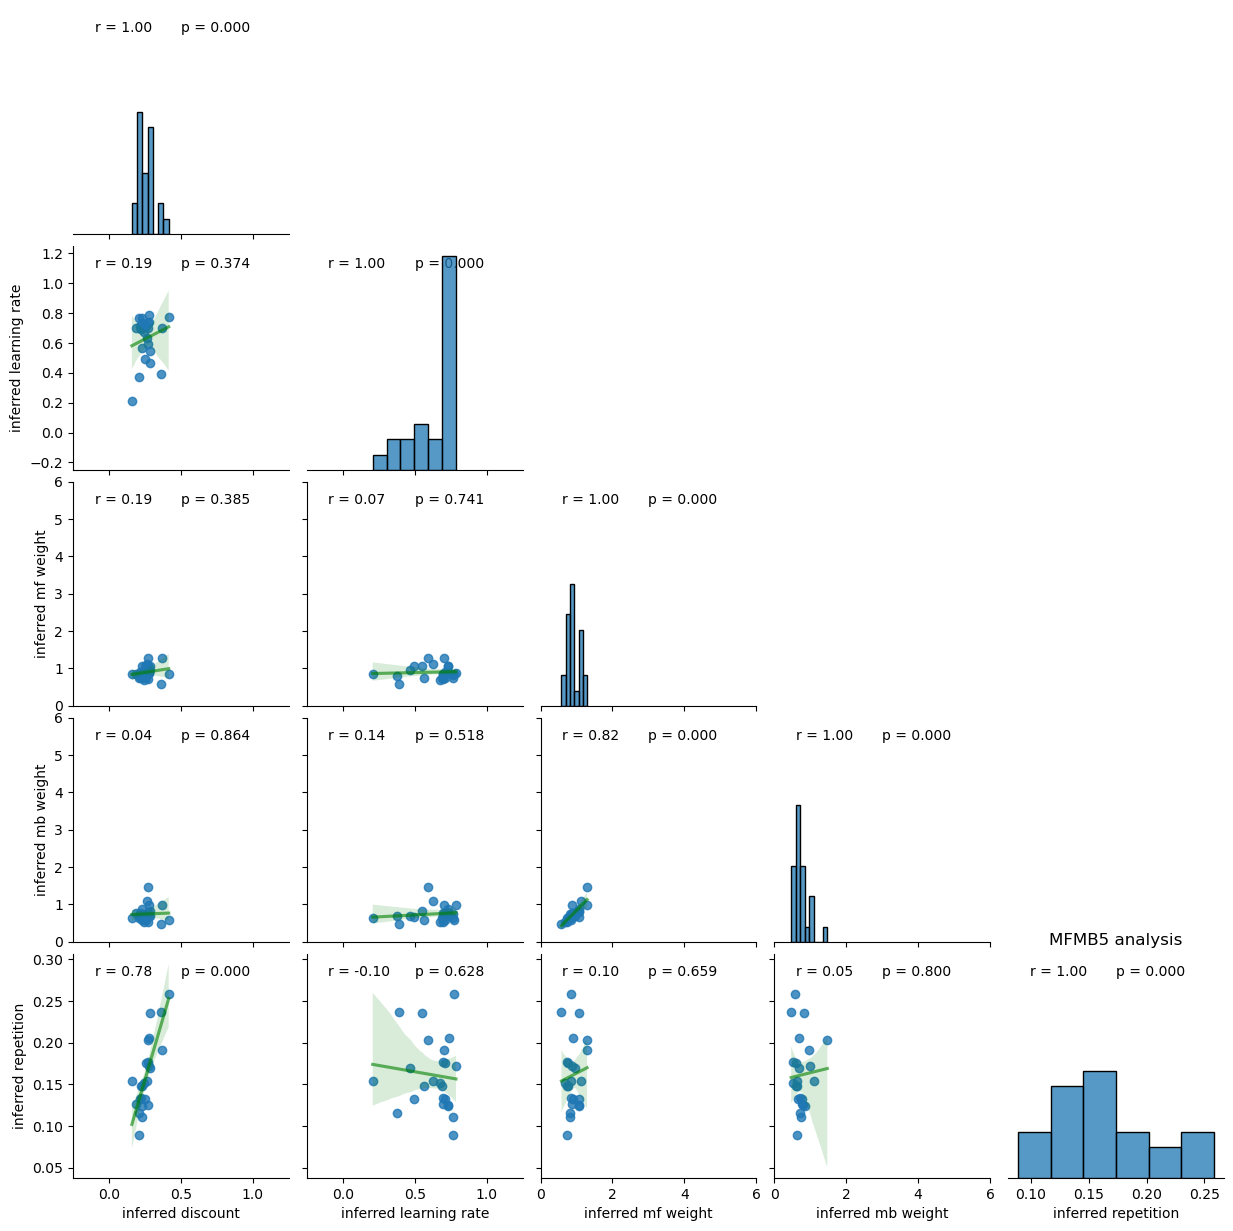

In [27]:
# prepare for saving results
# make base filename and folder string
BCC4_MFMB5_fname_base = "BCC4param_cross_fitting_"+MFMB5_agent_type
print(BCC4_MFMB5_fname_base)
# define folder where we want to save data
# make base filename and folder string
BCC4_MFMB5_base_dir = os.path.join(cross_fitting_folder,BCC4_MFMB5_fname_base[:-1])

num_steps = 500

BCC4_MFMB5_mean_df, BCC4_MFMB5_sample_df, BCC4_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, restrict_alpha, 
                                                                                 max_dt, BCC4_MFMB5_base_dir, 
                                                                                 global_experiment_parameters, BCC4_data["valid"], 
                                                                                 BCC4_MFMB5_fname_base, num_steps, BCC4_data, MFMB5_param_names)

BCC4_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, max_dt, 
                                                  min_alpha, BCC4_MFMB5_base_dir, global_experiment_parameters, 
                                                  BCC4_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB5_param_names]
f = sns.pairplot(data=BCC4_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# 3. MFMB4 data

MFMB4param_cross_fitting_BCC_3param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

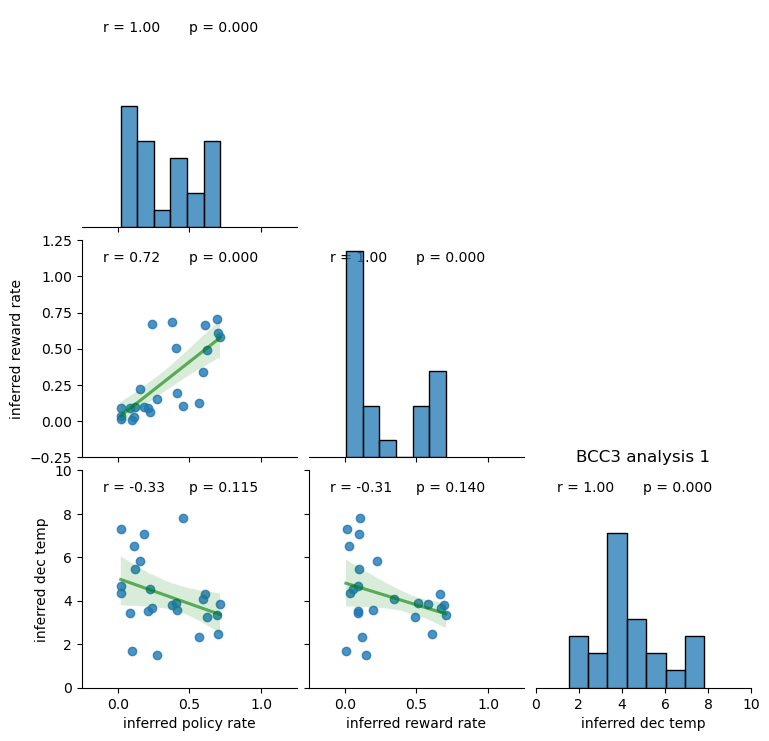

In [28]:
# load BCC3 fitting of MFMB4 data

MFMB4_BCC3_fname_base = "MFMB4param_cross_fitting_"+BCC3_agent_type
print(MFMB4_BCC3_fname_base)
# define folder where we want to save data
MFMB4_BCC3_base_dir = os.path.join(cross_fitting_folder,MFMB4_BCC3_fname_base[:-1])

num_steps = 600

MFMB4_BCC3_mean_df, MFMB4_BCC3_sample_df, MFMB4_BCC3_locs_df = load_BCC_results(BCC3_infer_h, MFMB4_BCC3_base_dir, 
                                                                                global_experiment_parameters, exp_mask, MFMB4_BCC3_fname_base, 
                                                                                num_steps, MFMB4_data, BCC3_param_names)
MFMB4_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, MFMB4_BCC3_base_dir, global_experiment_parameters, 
                                                      MFMB4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=MFMB4_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB4param_cross_fitting_BCC_4param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

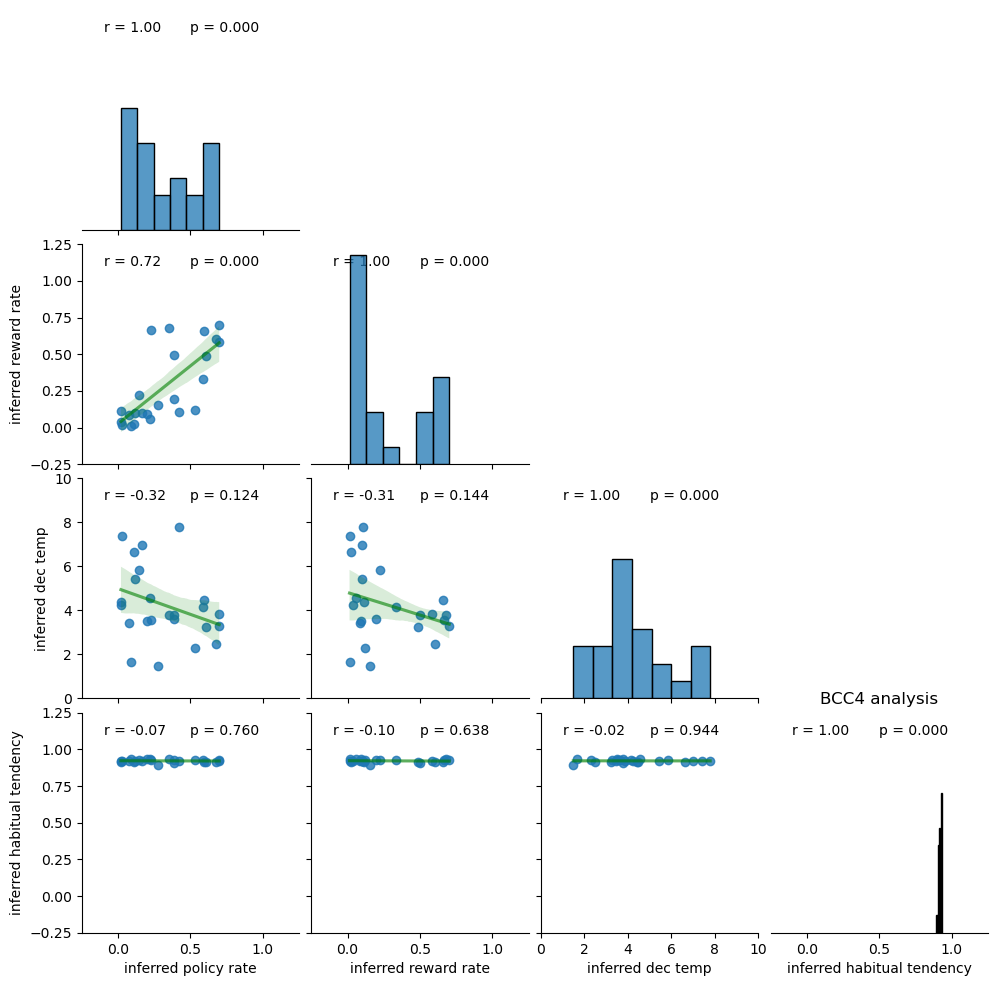

In [29]:
# BCC4 agent for MFMB4 data


MFMB4_BCC4_fname_base = "MFMB4param_cross_fitting_"+BCC4_agent_type
print(MFMB4_BCC4_fname_base)
# define folder where we want to save data
MFMB4_BCC4_base_dir = os.path.join(cross_fitting_folder,MFMB4_BCC4_fname_base[:-1])

num_steps = 600

MFMB4_BCC4_mean_df, MFMB4_BCC4_sample_df, MFMB4_BCC4_locs_df = load_BCC_results(BCC4_infer_h, MFMB4_BCC4_base_dir, 
                                                                                global_experiment_parameters, exp_mask, 
                                                                                MFMB4_BCC4_fname_base, num_steps, MFMB4_data, BCC4_param_names)
MFMB4_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, MFMB4_BCC4_base_dir, global_experiment_parameters, 
                                                      MFMB4_data["valid"], remove_old=False)

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC4_param_names]
f = sns.pairplot(data=MFMB4_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

mbmf_4param_recovery_
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

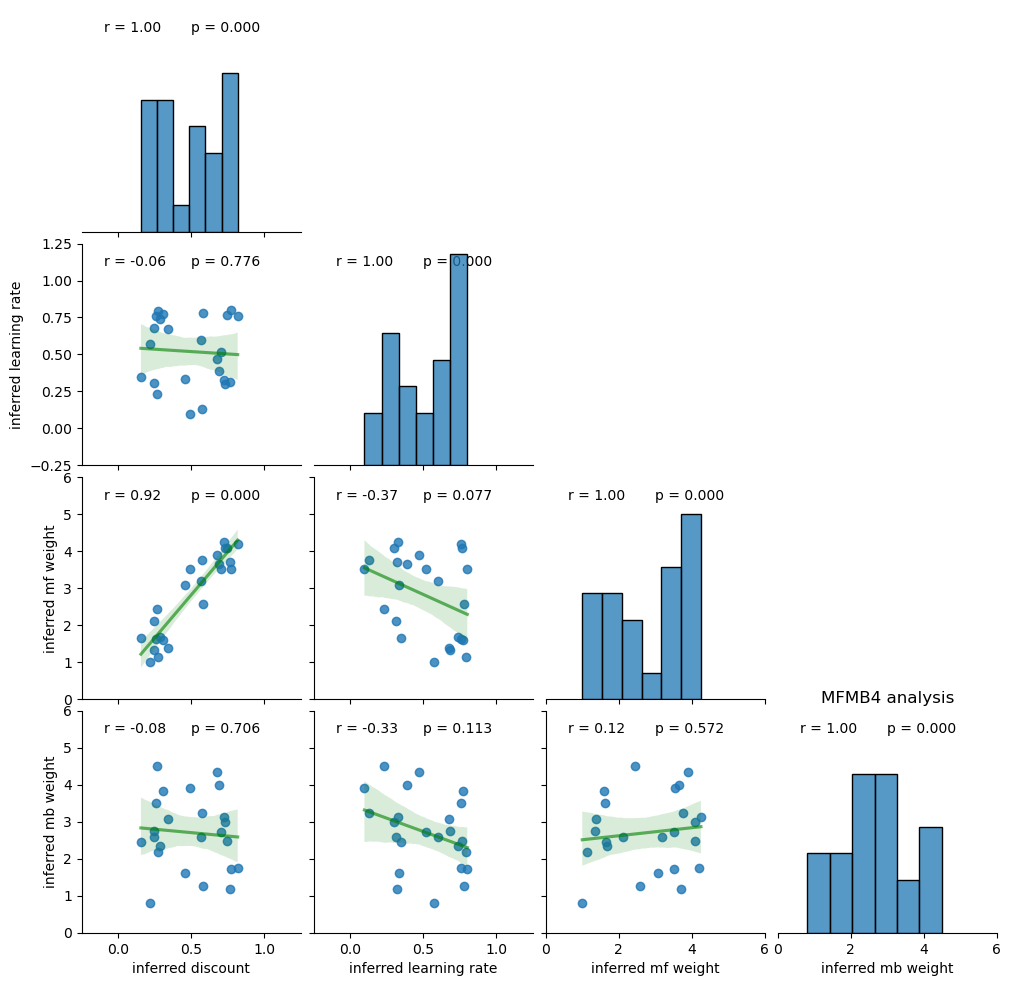

In [30]:
# prepare for saving results
# make base filename and folder string
MFMB4_MFMB4_fname_base = MFMB4_agent_type+"_recovery_"
print(MFMB4_MFMB4_fname_base)
# define folder where we want to save data
MFMB4_MFMB4_base_dir = os.path.join(recovery_folder,MFMB4_MFMB4_fname_base[:-1])

num_steps = 500

MFMB4_MFMB4_mean_df, MFMB4_MFMB4_sample_df, MFMB4_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, 
                                                                                    MFMB4_MFMB4_base_dir, global_experiment_parameters, 
                                                                                    MFMB4_data["valid"], MFMB4_MFMB4_fname_base, num_steps, 
                                                                                    MFMB4_data, MFMB4_param_names)

MFMB4_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, restrict_alpha, max_dt, min_alpha, 
                                                   MFMB4_MFMB4_base_dir, global_experiment_parameters, 
                                                   MFMB4_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=MFMB4_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB4param_cross_fitting_mbmf_5param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

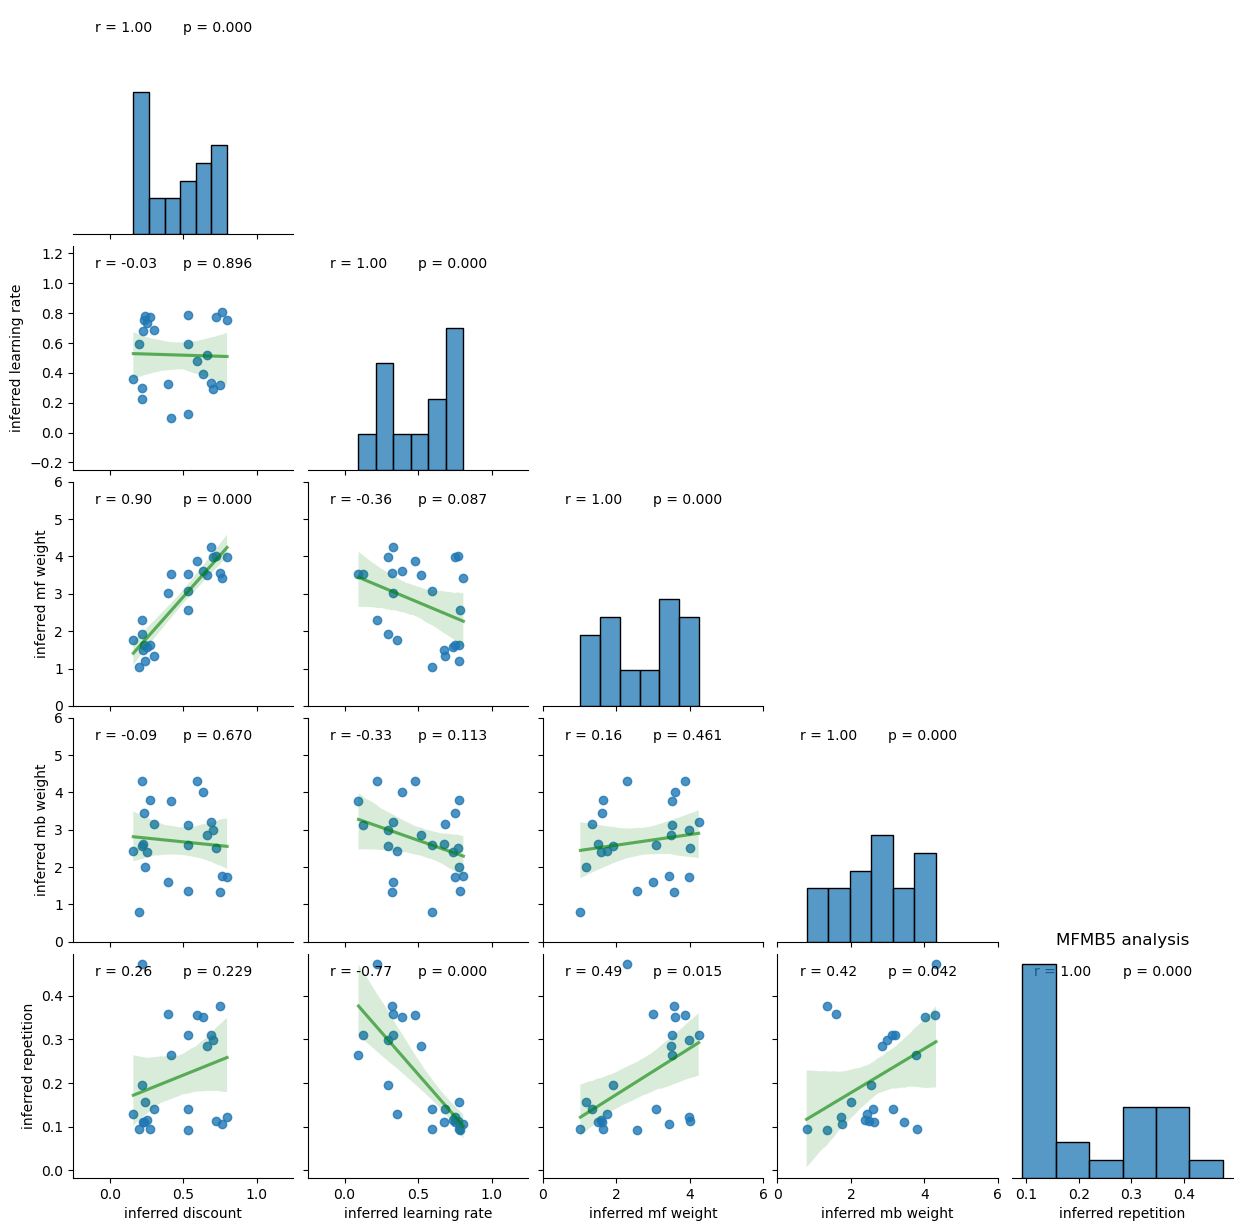

In [31]:
# prepare for saving results
# make base filename and folder string
MFMB4_MFMB5_fname_base = "MFMB4param_cross_fitting_"+MFMB5_agent_type
print(MFMB4_MFMB5_fname_base)
# define folder where we want to save data
# make base filename and folder string
MFMB4_MFMB5_base_dir = os.path.join(cross_fitting_folder,MFMB4_MFMB5_fname_base[:-1])

num_steps = 500

MFMB4_MFMB5_mean_df, MFMB4_MFMB5_sample_df, MFMB4_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, 
                                                                                    restrict_alpha, max_dt, MFMB4_MFMB5_base_dir, 
                                                                                    global_experiment_parameters, MFMB4_data["valid"], 
                                                                                    MFMB4_MFMB5_fname_base, num_steps, MFMB4_data, MFMB4_param_names)

MFMB4_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, max_dt, 
                                                   min_alpha, MFMB4_MFMB5_base_dir, global_experiment_parameters, 
                                                   MFMB4_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB5_param_names]
f = sns.pairplot(data=MFMB4_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# 4. MFMB5 data

MFMB5param_cross_fitting_BCC_3param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

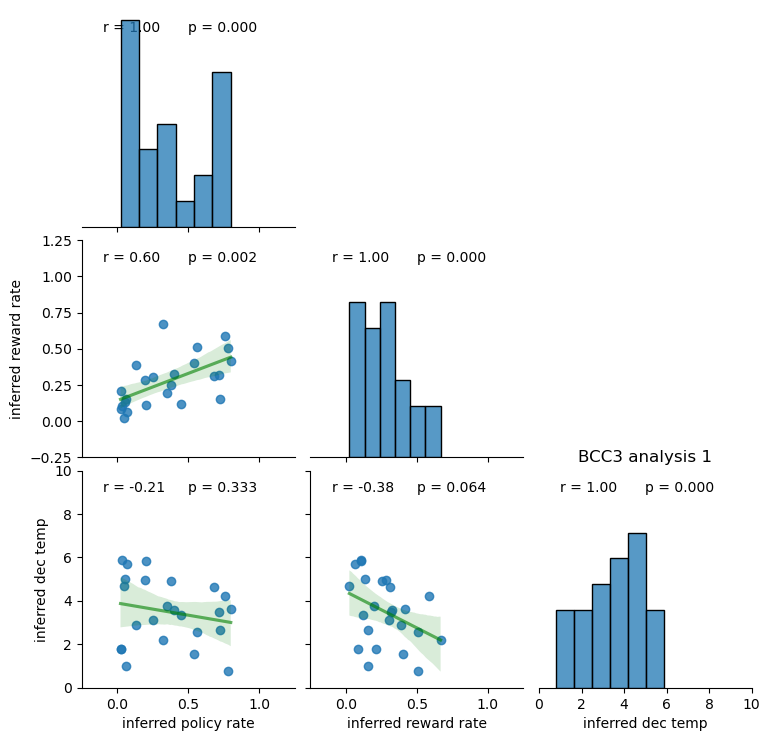

In [32]:
# load BCC3 fitting of MFMB5 data

MFMB5_BCC3_fname_base = "MFMB5param_cross_fitting_"+BCC3_agent_type
print(MFMB5_BCC3_fname_base)
# define folder where we want to save data
MFMB5_BCC3_base_dir = os.path.join(cross_fitting_folder,MFMB5_BCC3_fname_base[:-1])

num_steps = 600

MFMB5_BCC3_mean_df, MFMB5_BCC3_sample_df, MFMB5_BCC3_locs_df = load_BCC_results(BCC3_infer_h, MFMB5_BCC3_base_dir, 
                                                                                global_experiment_parameters, exp_mask, 
                                                                                MFMB5_BCC3_fname_base, num_steps, 
                                                                                MFMB5_data, BCC3_param_names)
MFMB5_BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC3_infer_h, MFMB5_BCC3_base_dir, global_experiment_parameters, 
                                                      MFMB5_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC3_param_names]
f = sns.pairplot(data=MFMB5_BCC3_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB5param_cross_fitting_BCC_4param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

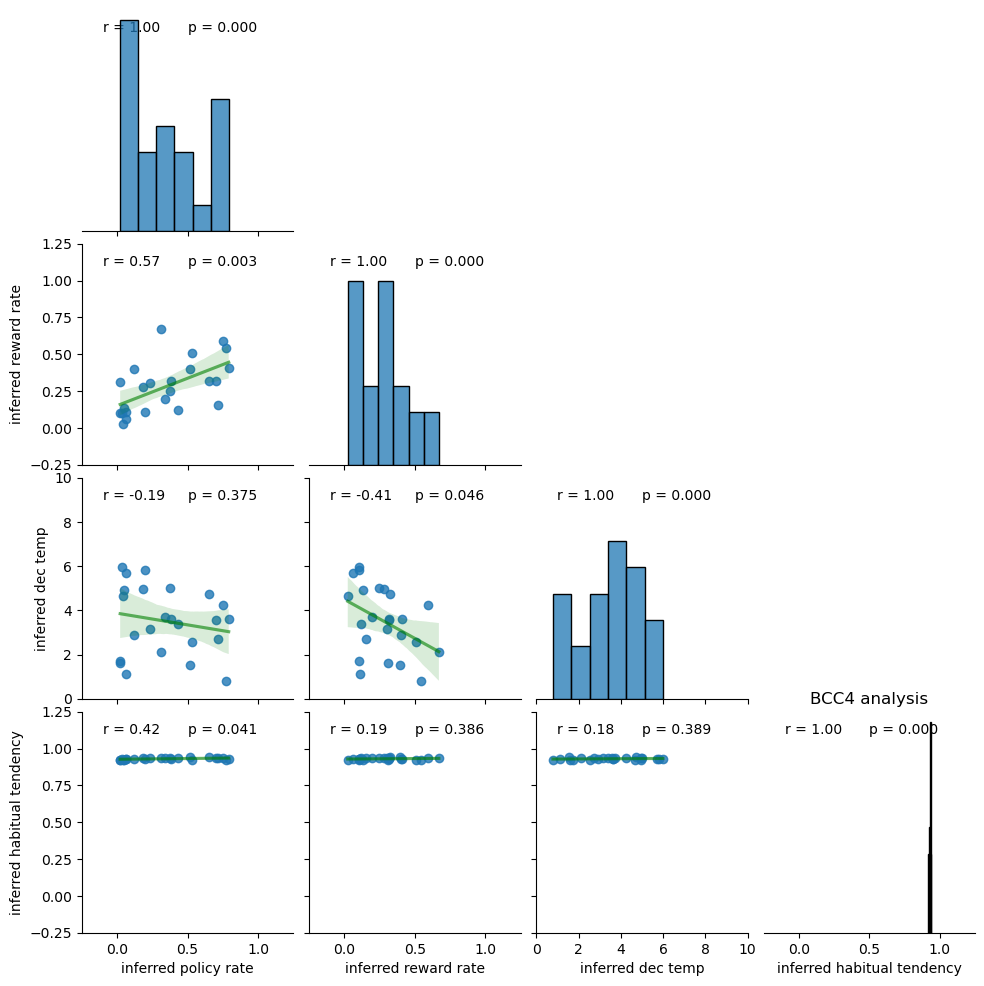

In [33]:
# BCC4 agent for MFMB5 data


MFMB5_BCC4_fname_base = "MFMB5param_cross_fitting_"+BCC4_agent_type
print(MFMB5_BCC4_fname_base)
# define folder where we want to save data
MFMB5_BCC4_base_dir = os.path.join(cross_fitting_folder,MFMB5_BCC4_fname_base[:-1])

num_steps = 600

MFMB5_BCC4_mean_df, MFMB5_BCC4_sample_df, MFMB5_BCC4_locs_df = load_BCC_results(BCC4_infer_h, MFMB5_BCC4_base_dir, 
                                                                                global_experiment_parameters, exp_mask, 
                                                                                MFMB5_BCC4_fname_base, num_steps, 
                                                                                MFMB5_data, BCC4_param_names)
MFMB5_BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, BCC4_infer_h, MFMB5_BCC4_base_dir, global_experiment_parameters, 
                                                      MFMB5_data["valid"], remove_old=False)

plt.figure()
vars_of_interest = ["inferred "+name for name in BCC4_param_names]
f = sns.pairplot(data=MFMB5_BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC4_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

MFMB5param_cross_fitting_mbmf_4param
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

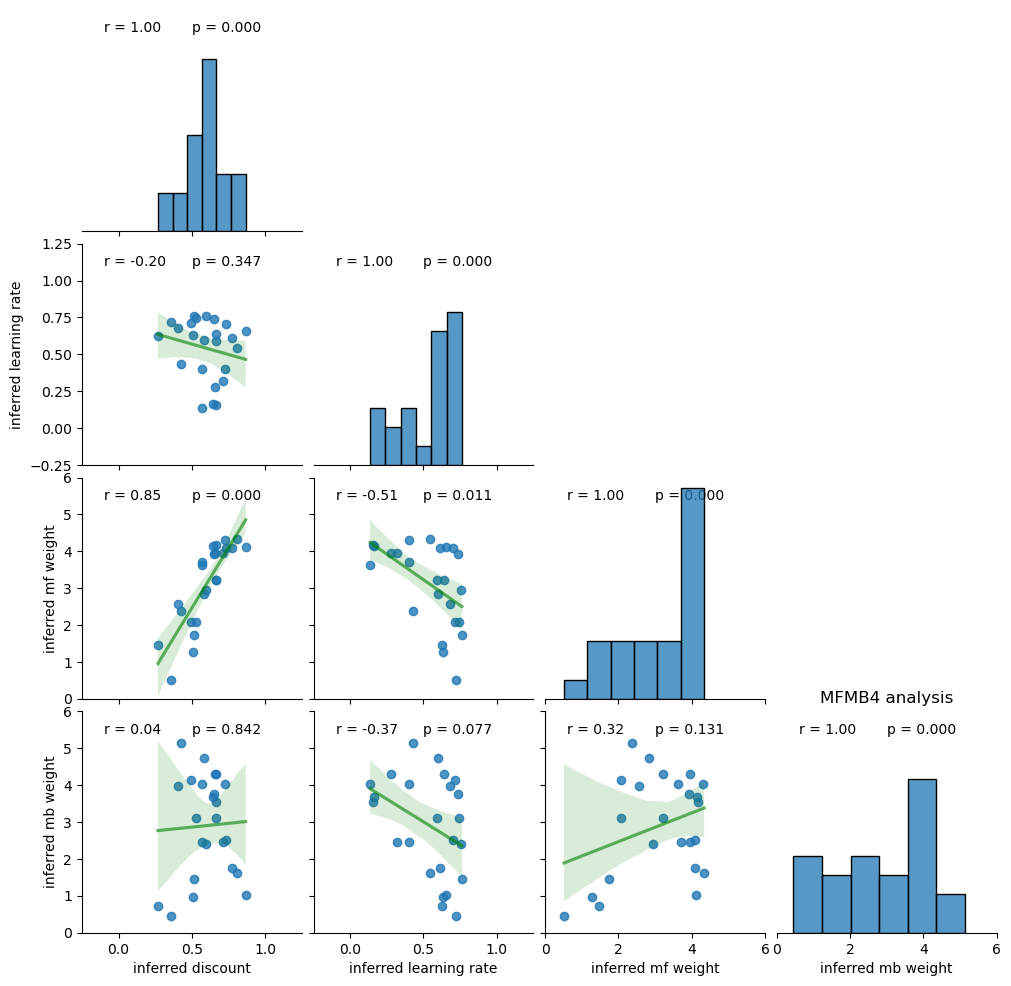

In [34]:
# prepare for saving results
# make base filename and folder string
MFMB5_MFMB4_fname_base = "MFMB5param_cross_fitting_"+MFMB4_agent_type
print(MFMB5_MFMB4_fname_base)
# define folder where we want to save data
# make base filename and folder string
MFMB5_MFMB4_base_dir = os.path.join(cross_fitting_folder,MFMB5_MFMB4_fname_base[:-1])

num_steps = 500

MFMB5_MFMB4_mean_df, MFMB5_MFMB4_sample_df, MFMB5_MFMB4_locs_df = load_MFMB_results(use_orig, MFMB4_use_p, restrict_alpha, max_dt, 
                                                                                    MFMB5_MFMB4_base_dir, global_experiment_parameters, 
                                                                                    MFMB5_data["valid"], MFMB5_MFMB4_fname_base, num_steps, 
                                                                                    MFMB5_data, MFMB4_param_names)

MFMB5_MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB4_use_p, restrict_alpha, max_dt, min_alpha, 
                                                   MFMB5_MFMB4_base_dir, global_experiment_parameters, MFMB5_data["valid"], remove_old=False)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=MFMB5_MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

mbmf_5param_recovery_
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

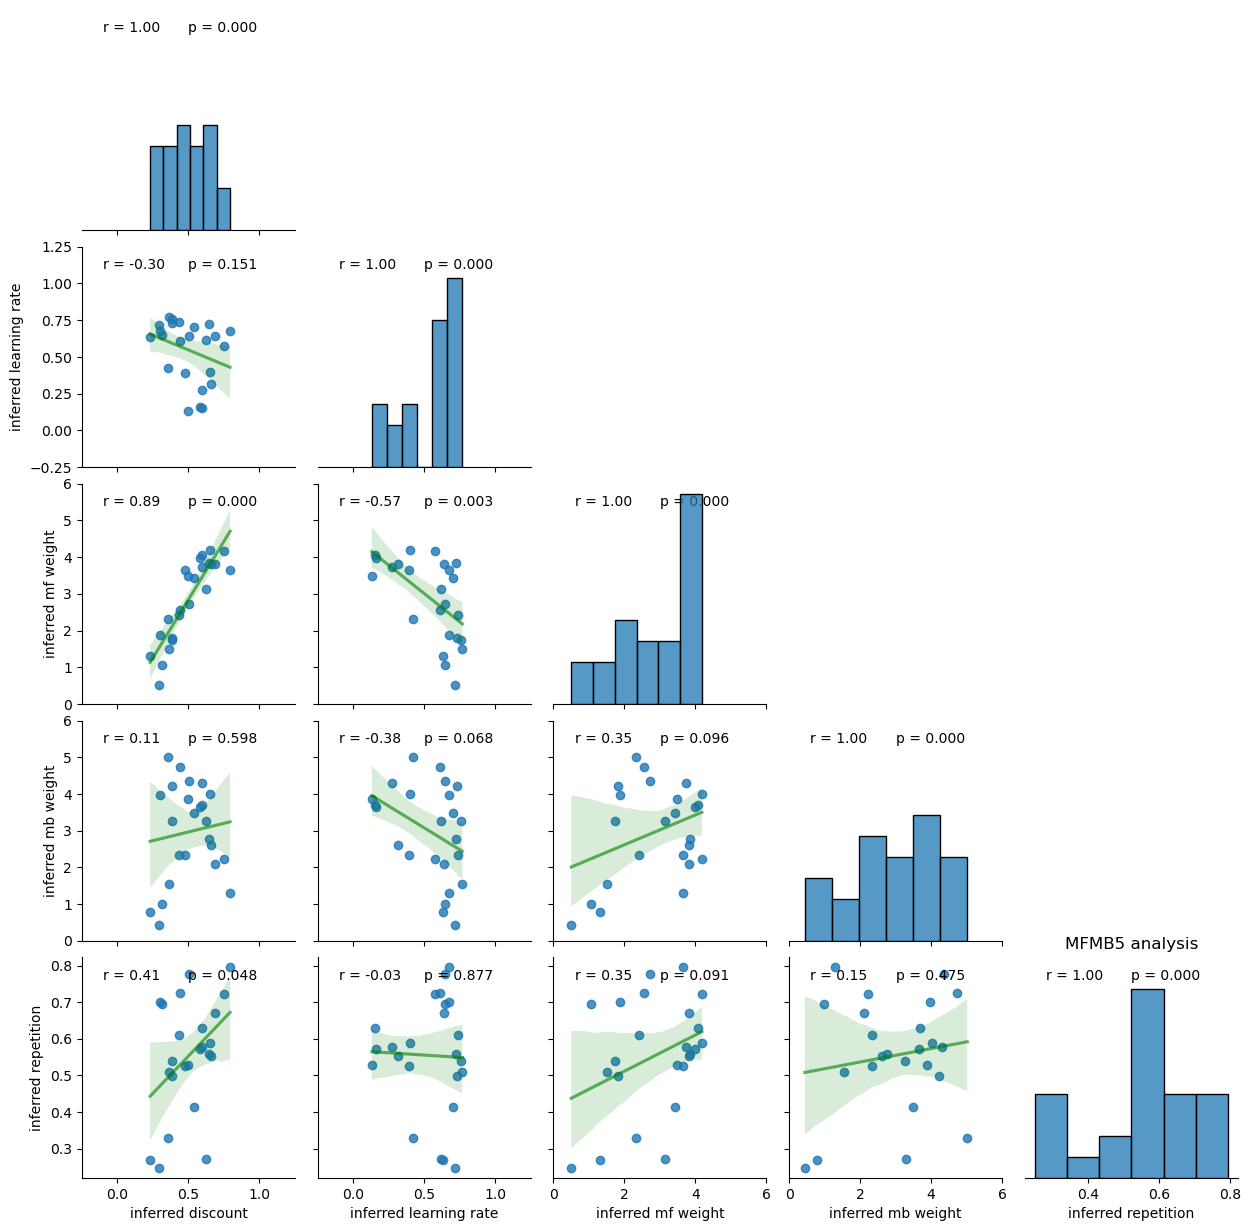

In [35]:
# prepare for saving results
# make base filename and folder string
MFMB5_MFMB5_fname_base = MFMB5_agent_type+"_recovery_"
print(MFMB5_MFMB5_fname_base)
# define folder where we want to save data
MFMB5_MFMB5_base_dir = os.path.join(recovery_folder,MFMB5_MFMB5_fname_base[:-1])

num_steps = 500

MFMB5_MFMB5_mean_df, MFMB5_MFMB5_sample_df, MFMB5_MFMB5_locs_df = load_MFMB_results(use_orig, MFMB5_use_p, 
                                                                                    restrict_alpha, max_dt, MFMB5_MFMB5_base_dir, 
                                                                                    global_experiment_parameters, MFMB5_data["valid"], 
                                                                                    MFMB5_MFMB5_fname_base, num_steps, MFMB5_data, MFMB4_param_names)

MFMB5_MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, MFMB5_use_p, restrict_alpha, max_dt, min_alpha, 
                                                   MFMB5_MFMB5_base_dir, global_experiment_parameters, MFMB5_data["valid"], remove_old=False)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB5_param_names]
f = sns.pairplot(data=MFMB5_MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()


# Get all WAICs

In [36]:
# BCC3 data

BCC3_BCC3_WAIC = -calculate_waic(BCC3_data, BCC3_BCC3_agent, BCC3_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_BCC4_WAIC = -calculate_waic(BCC3_data, BCC3_BCC4_agent, BCC3_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_MFMB4_WAIC = -calculate_waic(BCC3_data, BCC3_MFMB4_agent, BCC3_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_MFMB5_WAIC = -calculate_waic(BCC3_data, BCC3_MFMB5_agent, BCC3_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [37]:
BCC3_data_all_total_WAICs = torch.stack([BCC3_BCC3_WAIC, BCC3_BCC4_WAIC, BCC3_MFMB4_WAIC, BCC3_MFMB5_WAIC], dim=-1)

winning_model = BCC3_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*BCC3_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC3_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC3_data_all_total_WAICs)

BCC3 wins tensor(4)
BCC4 wins tensor(20)
MFMB4 wins tensor(0)
MFMB5 wins tensor(0)
torch.Size([24, 4])
tensor([1.6740e-01, 8.2857e-01, 4.0052e-03, 1.6807e-05])
tensor([0., 1., 0., 0.])
p model mean according to measure tensor([1.6740e-01, 8.2857e-01, 4.0052e-03, 1.6807e-05])
best model: tensor(1) exceedance prob tensor(0.9980)
is significantly different from uniform? TtestResult(statistic=160.65156458225135, pvalue=0.0, df=499)


In [38]:
# BCC4 data

BCC4_BCC3_WAIC = -calculate_waic(BCC4_data, BCC4_BCC3_agent, BCC4_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_BCC4_WAIC = -calculate_waic(BCC4_data, BCC4_BCC4_agent, BCC4_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_MFMB4_WAIC = -calculate_waic(BCC4_data, BCC4_MFMB4_agent, BCC4_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_MFMB5_WAIC = -calculate_waic(BCC4_data, BCC4_MFMB5_agent, BCC4_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [39]:
BCC4_data_all_total_WAICs = torch.stack([BCC4_BCC3_WAIC, BCC4_BCC4_WAIC, BCC4_MFMB4_WAIC, BCC4_MFMB5_WAIC], dim=-1)

winning_model = BCC4_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*BCC4_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC4_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC4_data_all_total_WAICs)

BCC3 wins tensor(2)
BCC4 wins tensor(22)
MFMB4 wins tensor(0)
MFMB5 wins tensor(0)
torch.Size([24, 4])
tensor([8.7381e-02, 9.1262e-01, 1.9993e-07, 9.1561e-07])
tensor([0., 1., 0., 0.])
p model mean according to measure tensor([8.7381e-02, 9.1262e-01, 1.9993e-07, 9.1561e-07])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=228.86049758782596, pvalue=0.0, df=499)


In [40]:
# MFMB4 data

MFMB4_BCC3_WAIC = -calculate_waic(MFMB4_data, MFMB4_BCC3_agent, MFMB4_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_BCC4_WAIC = -calculate_waic(MFMB4_data, MFMB4_BCC4_agent, MFMB4_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_MFMB4_WAIC = -calculate_waic(MFMB4_data, MFMB4_MFMB4_agent, MFMB4_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_MFMB5_WAIC = -calculate_waic(MFMB4_data, MFMB4_MFMB5_agent, MFMB4_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [41]:
MFMB4_data_all_total_WAICs = torch.stack([MFMB4_BCC3_WAIC, MFMB4_BCC4_WAIC, MFMB4_MFMB4_WAIC, MFMB4_MFMB5_WAIC], dim=-1)

winning_model = MFMB4_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*MFMB4_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB4_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB4_data_all_total_WAICs)

BCC3 wins tensor(0)
BCC4 wins tensor(0)
MFMB4 wins tensor(17)
MFMB5 wins tensor(7)
torch.Size([24, 4])
tensor([3.7015e-10, 6.4501e-11, 6.7736e-01, 3.2264e-01])
tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 3.9736e-21])
p model mean according to measure tensor([3.7015e-10, 6.4501e-11, 6.7736e-01, 3.2264e-01])
best model: tensor(2) exceedance prob tensor(0.9540)
is significantly different from uniform? TtestResult(statistic=96.26542726166078, pvalue=0.0, df=499)


In [42]:
# MFMB5 data

MFMB5_BCC3_WAIC = -calculate_waic(MFMB5_data, MFMB5_BCC3_agent, MFMB5_BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_BCC4_WAIC = -calculate_waic(MFMB5_data, MFMB5_BCC4_agent, MFMB5_BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_MFMB4_WAIC = -calculate_waic(MFMB5_data, MFMB5_MFMB4_agent, MFMB5_MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_MFMB5_WAIC = -calculate_waic(MFMB5_data, MFMB5_MFMB5_agent, MFMB5_MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

In [43]:
MFMB5_data_all_total_WAICs = torch.stack([MFMB5_BCC3_WAIC, MFMB5_BCC4_WAIC, MFMB5_MFMB4_WAIC, MFMB5_MFMB5_WAIC], dim=-1)

winning_model = MFMB5_data_all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*MFMB5_data_all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB5_data_all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB5_data_all_total_WAICs)

BCC3 wins tensor(0)
BCC4 wins tensor(2)
MFMB4 wins tensor(12)
MFMB5 wins tensor(10)
torch.Size([24, 4])
tensor([0.0044, 0.0789, 0.4988, 0.4178])
tensor([0.0000e+00, 0.0000e+00, 1.5619e-09, 1.0000e+00])
p model mean according to measure tensor([0.0044, 0.0789, 0.4988, 0.4178])
best model: tensor(2) exceedance prob tensor(0.7020)
is significantly different from uniform? TtestResult(statistic=55.18704974910316, pvalue=6.969298806220795e-215, df=499)


In [44]:
BCC4_data_sub_WAICs = torch.stack([BCC4_BCC4_WAIC, BCC4_MFMB4_WAIC], dim=-1)

winning_model = BCC4_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC4_data_sub_WAICs)

BCC4 wins tensor(24)
MFMB4 wins tensor(0)
torch.Size([24, 2])
tensor([1.0000e+00, 1.9994e-07])
tensor([1., 0.])
p model mean according to measure tensor([1.0000e+00, 1.9994e-07])
best model: tensor(0) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=187387263.71073025, pvalue=0.0, df=499)


/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [45]:
MFMB4_data_sub_WAICs = torch.stack([MFMB4_BCC4_WAIC, MFMB4_MFMB4_WAIC], dim=-1)

winning_model = MFMB4_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*MFMB4_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB4_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB4_data_sub_WAICs)

BCC4 wins tensor(1)
MFMB4 wins tensor(23)
torch.Size([24, 2])
tensor([0.0414, 0.9586])
tensor([0., 1.])
p model mean according to measure tensor([0.0414, 0.9586])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=267.72279661825394, pvalue=0.0, df=499)


In [46]:
BCC4_data_sub_WAICs = torch.stack([BCC4_BCC4_WAIC, BCC4_MFMB5_WAIC], dim=-1)

winning_model = BCC4_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*BCC4_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*BCC4_data_sub_WAICs)

BCC4 wins tensor(24)
MFMB5 wins tensor(0)
torch.Size([24, 2])
tensor([1.0000e+00, 9.1571e-07])
tensor([1., 0.])
p model mean according to measure tensor([1.0000e+00, 9.1571e-07])
best model: tensor(0) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=187387263.71073025, pvalue=0.0, df=499)


In [47]:
MFMB5_data_sub_WAICs = torch.stack([MFMB5_BCC4_WAIC, MFMB5_MFMB5_WAIC], dim=-1)

winning_model = MFMB5_data_sub_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

p_model = torch.nn.functional.softmax(-2*MFMB5_data_sub_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*MFMB5_data_sub_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

calculate_exceedance_prob(-2*MFMB4_data_sub_WAICs)

BCC4 wins tensor(2)
MFMB5 wins tensor(22)
torch.Size([24, 2])
tensor([0.0834, 0.9166])
tensor([0., 1.])
p model mean according to measure tensor([0.0414, 0.9586])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=240.2878515553547, pvalue=0.0, df=499)
